# Inputs preparation and simulation

This notebook show a complete example of simulation for the toy model of the building. It covers (Figure 1):

- modeling: 
     - obtain dissasembled thermal circuit from files describing the walls and the thermal circuits (function `bldg2TCd()`);
     - assemble the thermal circuits (functions `assemble_TCd_matrix()` and `assemble_lists2matrix()`);
     - state-space representation from thermal circuit (function `tc2ss()`).

- input data set:
    - get weather data: outdoor temperature and direct, diffuse and reflected solar radiation on tilted surfaces (functions `read_epw()` and `sol_rad_tilt_surf()`);
    - define the other inputs, such as indoor temperature set points, auxialiry flow-rates;

- simulation:
    - prepare the inputs from input description of the state-space  ($u_s$) and the _input data set_ (function `inputs_in_time()`);
    - integrate in time by using Euler explicit and implicit methods.

![work_flow](./pd/bldg/work_flow.svg)

> Figure 1. Work flow for building simulation by using `dm4bem` module. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Assembling and converting the thermal circuits to state-space
Consider the disassembled thermal circuits shown in Figure 1 that we want to assemble as shown in Figure 2 and then obtain the state-space representation.

![disassambled_TC](./pd/bldg/ass_TCd.svg)
> Figure 1. Four disassembled thermal circuits: wall_out, TC0, TC1, TC2, TC3.

![disassambled_TC](./pd/bldg/ass_TC.svg)
> Figure 2. The assembling of the four circuits from Figure 1.

The steps to obtain a state-space model from thermal circuits described in a folder are:
1. Obtain the disassambled set of thermal circuits from data given in a folder.
2. Assemble the set of thermal circuits.
3. Transform the thermal circuit into state-space representation.

In [2]:
# Obtain state-space representation
# =================================
# Disassembled thermal circuits
folder_path = "pd/bldg"
TCd = dm4bem.bldg2TCd(folder_path,
                      TC_auto_number=True)

# Assembled thermal circuit using assembly_lists.csv'
ass_lists = pd.read_csv(folder_path + '/assembly_lists.csv')
ass_matrix = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_matrix)

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

## Eigenvalues, time step and duration

The state-space representation allows us to do the eigenvalues analysis and to find:

- maximum time step: $\Delta t_{max} = 2 \mathrm{min} (-1 / \lambda)$, where $\lambda$ is the vector of eigenvalues of the state matrix As;
- minimum settling time: $t_{settle} = 4 \mathrm{max} (-1 / \lambda$). 

In [3]:
# Eigenvalue analysis
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:')
print([f'{T:.2f} s' for T in -1 / λ])

dt_max = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dt_max:.2f} s = {dt_max / 60:.2f} min')

t_settle = 4 * max(-1. / λ)
print(f'Minimum settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / 3600:.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# time step
dt = np.floor(dt_max / 60) * 60   # s
print(f'Time step Δt = {dt} s = {dt / 60:.0f} min')

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
print(f'Duration: \
{duration:.0f} s = \
{duration / 60:.1f} min = \
{duration / 3600:.2f} h = \
{duration / (3600 * 24):.2f} days')

Time constants:
['249.30 s', '4093.21 s', '6729.13 s', '44033.06 s']

Maximum time step: 498.60 s = 8.31 min
Minimum settling time: 176132 s = 2935.5 min = 48.93 h = 2.04 days
Time step Δt = 480.0 s = 8 min
Duration: 176400 s = 2940.0 min = 49.00 h = 2.04 days


## Create input data set for step response

The [step response](https://en.m.wikipedia.org/wiki/Step_response) consists of the time response of the system when one or more inputs change instantaneously at time $t = 0$. The inputs of the system are the temperature ($T_o$, $T_{i,sp}$) and flow-rate sources ($\dot{Q}_a$, $\Phi_o$, $\Phi_i$, $\Phi_a$).

The input vector in time, $u$, is a DataFrame having as index the time (note that the year is __2000__ by convention) and as columns the values of the inputs arranged in the order given by the vector us (from the state-space representation). The transformation from inputs data set to the input vector is dne by the function `inputs_in_time()`.

In [5]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)
Ti_sp = 20 * np.ones(n)
Φa = 0 * np.ones(n)
Qa = Φo = Φi = Φa

data = {'To': To, 'Ti_sp': Ti_sp, 'Qa': Qa, 'Φo': Φo, 'Φi': Φi, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u

,c1_q0,c2_q0,c3_q0,ow0_q0,c1_θ0,c2_θ0,ow0_θ0,ow0_θ4
2000-01-01 00:00:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:08:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:16:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:24:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:32:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2000-01-03 00:16:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:24:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:32:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:40:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0


## Simulation

### Step response

#### Initial conditions

In [6]:
# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0
θ_imp = θ_exp

#### Time integration

The formula for [Euler](https://en.m.wikipedia.org/wiki/Euler_method)  integration is:

$$ \theta_{k+1} = (I + \Delta t A_s) \theta _k + \Delta t B_s u_k $$

for forward (or explicit) and:

$$\theta_{k+1} = (I - \Delta t A_s)^{-1} ( \theta _k + \Delta t B_s u_k )$$

for backward (or implicit) integration.

In [7]:
I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

#### Output values

Once the state variables, i.e. the temperatures in nodes that have capacities $\theta_C$, are found, the temperatures in the other nodes are:

$$y = C_s \theta + D_s u$$.

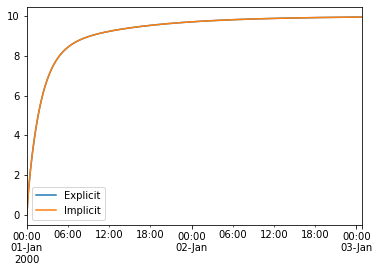

In [8]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
y.plot();

> Figure 3. Step response by using Euler explicit and Euler implicit integration methods.

### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [9]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [10]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [12]:
filename = '../weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

The yearly weather data set is from different years. By convenction, we set the year at `2000`. Then, we select the data from start date to end date and resample the weather data to the time step used in simulation.

In [13]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

weather = weather.resample(str(dt) + 'S').interpolate(method='linear')

##### Set of temperature sources

The set of temperature sources contains:
- $T_o$ - outdor temperature;
- $T_{i, sp}$ - indoor temperature set-point.

In [14]:
# Temperature sources
To = weather['temp_air']
Ti_sp = 20 * np.ones(weather.shape[0])

##### Set of flow-rate sources 

__Total solar irradiance on the outdoor wall__

For the surface orientation of the outdoor wall, given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the direct, diffuse irradiance, and reflected irradiance solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance), in W/m², on a tilted surface. The total irradiance, $E_{tot}$, is the sum of direct, diffuse and reflected irradiances.

In [16]:
# total solar irradiance
wall_out = pd.read_csv('pd/bldg/walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

__Flow-rate sources__

$\Phi_o$: solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\Phi_a$: short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\dot{Q}_a$: auxiliary heat flows (from occupants, electrical devices, etc.), in W.

In [17]:
# Window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g = 9         # m2, surface area of glass

# Flow-rate sources
# solar radiation
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot
Φa = α_gSW * S_g * Etot

# auxiliary (internal) sources
Qa = 0 * np.ones(weather.shape[0])

##### Input vector

The input vector $u$ is obtained from the _input_ (i.e. sources) _data set_ arranged according to the order given by $u_s$ from state-space representation.

In [18]:
# Input data set
input_data_set = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Qa': Qa, 'Φo': Φo, 'Φi': Φi, 'Φa': Φa})
# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

#### Simulation

##### Time integration

[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [19]:
# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0

I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]

started from innitial conditions, yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [ ]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T

Kp = TC['G']['c3_q0']   # controller gain
q_HVAC = Kp * (u['c3_q0'] - y_exp['c2_θ0'])

##### Results plot

In [ ]:
data = pd.DataFrame({'To': To, 'θi': y_exp['c2_θ0'],
                     'Etot': Etot, 'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show()

> Figure 4. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

Interchange the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$).

## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. C. Ghiaus (2021). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198 (ref.)
[DOI 10.1007/978-3-030-76477-7_5](https://doi.org/10.1007/978-3-030-76477-7_5), open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

7. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University